In [1]:
##########################################
# Fama French 3 Factors                  #
# Qingyi (Freda) Song Drechsler          #
# Date: April 2018                       #
# Updated: June 2020                     #
##########################################

import pandas as pd
import numpy as np
import datetime as dt
import wrds
#import psycopg2 
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats

In [2]:
###################
# Connect to WRDS #
###################
conn=wrds.Connection()

WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [3]:
###################
# Compustat Block #
###################
comp = conn.raw_sql("""
                    select gvkey, datadate, at, pstkl, txditc,
                    pstkrv, seq, pstk
                    from comp.funda
                    where indfmt='INDL' 
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    and datadate >= '01/01/1959'
                    """, date_cols=['datadate'])

comp['year']=comp['datadate'].dt.year

In [4]:
# create preferrerd stock
comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])
comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps'])
comp['txditc']=comp['txditc'].fillna(0)

In [8]:
# Create book equity
comp['be'] = comp['seq'] + comp['txditc'] - comp['ps']

# Fix the TypeError by handling NA values properly
comp['be'] = np.where(comp['be'].fillna(0) > 0, comp['be'], np.nan)

In [9]:
# number of years in Compustat
comp=comp.sort_values(by=['gvkey','datadate'])
comp['count']=comp.groupby(['gvkey']).cumcount()

comp=comp[['gvkey','datadate','year','be','count']]

In [10]:
###################
# CRSP Block      #
###################
# sql similar to crspmerge macro
crsp_m = conn.raw_sql("""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
                      a.ret, a.retx, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1959' and '12/31/2017'
                      and b.exchcd between 1 and 3
                      """, date_cols=['date']) 

# change variable format to int
crsp_m[['permco','permno','shrcd','exchcd']]=crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

# Line up date to be end of month
crsp_m['jdate']=crsp_m['date']+MonthEnd(0)

In [11]:
# add delisting return
dlret = conn.raw_sql("""
                     select permno, dlret, dlstdt 
                     from crsp.msedelist
                     """, date_cols=['dlstdt'])

dlret.permno=dlret.permno.astype(int)
#dlret['dlstdt']=pd.to_datetime(dlret['dlstdt'])
dlret['jdate']=dlret['dlstdt']+MonthEnd(0)

crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])
crsp['dlret']=crsp['dlret'].fillna(0)
crsp['ret']=crsp['ret'].fillna(0)

# retadj factors in the delisting returns
crsp['retadj']=(1+crsp['ret'])*(1+crsp['dlret'])-1

# calculate market equity
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
crsp=crsp.drop(['dlret','dlstdt','prc','shrout'], axis=1)
crsp=crsp.sort_values(by=['jdate','permco','me'])

In [12]:
### Aggregate Market Cap ###
# sum of me across different permno belonging to same permco a given date
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()

# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index()

# join by jdate/maxme to find the permno
crsp1=pd.merge(crsp, crsp_maxme, how='inner', on=['jdate','permco','me'])

# drop me column and replace with the sum me
crsp1=crsp1.drop(['me'], axis=1)

# join with sum of me to get the correct market cap info
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco'])

# sort by permno and date and also drop duplicates
crsp2=crsp2.sort_values(by=['permno','jdate']).drop_duplicates()


In [13]:
# keep December market cap
crsp2['year']=crsp2['jdate'].dt.year
crsp2['month']=crsp2['jdate'].dt.month
decme=crsp2[crsp2['month']==12]
decme=decme[['permno','date','jdate','me','year']].rename(columns={'me':'dec_me'})

### July to June dates
crsp2['ffdate']=crsp2['jdate']+MonthEnd(-6)
crsp2['ffyear']=crsp2['ffdate'].dt.year
crsp2['ffmonth']=crsp2['ffdate'].dt.month
crsp2['1+retx']=1+crsp2['retx']
crsp2=crsp2.sort_values(by=['permno','date'])

In [14]:
# cumret by stock
crsp2['cumretx']=crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()

# lag cumret
crsp2['lcumretx']=crsp2.groupby(['permno'])['cumretx'].shift(1)

# lag market cap
crsp2['lme']=crsp2.groupby(['permno'])['me'].shift(1)

# if first permno then use me/(1+retx) to replace the missing value
crsp2['count']=crsp2.groupby(['permno']).cumcount()
crsp2['lme']=np.where(crsp2['count']==0, crsp2['me']/crsp2['1+retx'], crsp2['lme'])

# baseline me
mebase=crsp2[crsp2['ffmonth']==1][['permno','ffyear', 'lme']].rename(columns={'lme':'mebase'})

# merge result back together
crsp3=pd.merge(crsp2, mebase, how='left', on=['permno','ffyear'])
crsp3['wt']=np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])

decme['year']=decme['year']+1
decme=decme[['permno','year','dec_me']]

In [15]:
# Info as of June
crsp3_jun = crsp3[crsp3['month']==6]

crsp_jun = pd.merge(crsp3_jun, decme, how='inner', on=['permno','year'])
crsp_jun=crsp_jun[['permno','date', 'jdate', 'shrcd','exchcd','retadj','me','wt','cumretx','mebase','lme','dec_me']]
crsp_jun=crsp_jun.sort_values(by=['permno','jdate']).drop_duplicates()

In [16]:
#######################
# CCM Block           #
#######################
ccm=conn.raw_sql("""
                  select gvkey, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """, date_cols=['linkdt', 'linkenddt'])

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

ccm1=pd.merge(comp[['gvkey','datadate','be', 'count']],ccm,how='left',on=['gvkey'])
ccm1['yearend']=ccm1['datadate']+YearEnd(0)
ccm1['jdate']=ccm1['yearend']+MonthEnd(6)

In [17]:
# set link date bounds
ccm2=ccm1[(ccm1['jdate']>=ccm1['linkdt'])&(ccm1['jdate']<=ccm1['linkenddt'])]
ccm2=ccm2[['gvkey','permno','datadate','yearend', 'jdate','be', 'count']]

# link comp and crsp
ccm_jun=pd.merge(crsp_jun, ccm2, how='inner', on=['permno', 'jdate'])
ccm_jun['beme']=ccm_jun['be']*1000/ccm_jun['dec_me']


In [18]:
# select NYSE stocks for bucket breakdown
# exchcd = 1 and positive beme and positive me and shrcd in (10,11) and at least 2 years in comp
nyse=ccm_jun[(ccm_jun['exchcd']==1) & (ccm_jun['beme']>0) & (ccm_jun['me']>0) & \
             (ccm_jun['count']>=1) & ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))]

# size breakdown
nyse_sz=nyse.groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})

# beme breakdown
nyse_bm=nyse.groupby(['jdate'])['beme'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_bm=nyse_bm[['jdate','30%','70%']].rename(columns={'30%':'bm30', '70%':'bm70'})

nyse_breaks = pd.merge(nyse_sz, nyse_bm, how='inner', on=['jdate'])

# join back size and beme breakdown
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])

In [19]:
# function to assign sz and bm bucket
def sz_bucket(row):
    if row['me']==np.nan:
        value=''
    elif row['me']<=row['sizemedn']:
        value='S'
    else:
        value='B'
    return value

def bm_bucket(row):
    if 0<=row['beme']<=row['bm30']:
        value = 'L'
    elif row['beme']<=row['bm70']:
        value='M'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=''
    return value


In [22]:
import numpy as np

# Ensure missing values are properly handled
ccm1_jun['beme'] = ccm1_jun['beme'].fillna(0)
ccm1_jun['me'] = ccm1_jun['me'].fillna(0)
ccm1_jun['count'] = ccm1_jun['count'].fillna(0)

# Convert count to an integer if necessary (avoids float issues)
ccm1_jun['count'] = ccm1_jun['count'].astype(int)

# Assign size portfolio
mask = (ccm1_jun['beme'] > 0) & (ccm1_jun['me'] > 0) & (ccm1_jun['count'] >= 1)
ccm1_jun.loc[mask, 'szport'] = ccm1_jun.loc[mask].apply(sz_bucket, axis=1)
ccm1_jun.loc[~mask, 'szport'] = ''

# Assign book-to-market portfolio
ccm1_jun.loc[mask, 'bmport'] = ccm1_jun.loc[mask].apply(bm_bucket, axis=1)
ccm1_jun.loc[~mask, 'bmport'] = ''

# Create positive book-to-market and non-missing portfolio variables
ccm1_jun['posbm'] = 0
ccm1_jun.loc[mask, 'posbm'] = 1

ccm1_jun['nonmissport'] = 0
ccm1_jun.loc[ccm1_jun['bmport'] != '', 'nonmissport'] = 1


In [23]:
# store portfolio assignment as of June
june=ccm1_jun[['permno','date', 'jdate', 'bmport','szport','posbm','nonmissport']]
june['ffyear']=june['jdate'].dt.year

# merge back with monthly records
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj','me','wt','cumretx','ffyear','jdate']]
ccm3=pd.merge(crsp3, 
        june[['permno','ffyear','szport','bmport','posbm','nonmissport']], how='left', on=['permno','ffyear'])

# keeping only records that meet the criteria
ccm4=ccm3[(ccm3['wt']>0)& (ccm3['posbm']==1) & (ccm3['nonmissport']==1) & 
          ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]


C:\Users\mason\AppData\Local\Temp\ipykernel_31048\1430860703.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june['ffyear']=june['jdate'].dt.year


In [24]:
############################
# Form Fama French Factors #
############################

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

In [25]:

# value-weigthed return
vwret=ccm4.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret['sbport']=vwret['szport']+vwret['bmport']

# firm count
vwret_n=ccm4.groupby(['jdate','szport','bmport'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
vwret_n['sbport']=vwret_n['szport']+vwret_n['bmport']

# tranpose
ff_factors=vwret.pivot(index='jdate', columns='sbport', values='vwret').reset_index()
ff_nfirms=vwret_n.pivot(index='jdate', columns='sbport', values='n_firms').reset_index()


C:\Users\mason\AppData\Local\Temp\ipykernel_31048\1824952709.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vwret=ccm4.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret'})


In [26]:
# create SMB and HML factors
ff_factors['WH']=(ff_factors['BH']+ff_factors['SH'])/2
ff_factors['WL']=(ff_factors['BL']+ff_factors['SL'])/2
ff_factors['WHML'] = ff_factors['WH']-ff_factors['WL']

ff_factors['WB']=(ff_factors['BL']+ff_factors['BM']+ff_factors['BH'])/3
ff_factors['WS']=(ff_factors['SL']+ff_factors['SM']+ff_factors['SH'])/3
ff_factors['WSMB'] = ff_factors['WS']-ff_factors['WB']
ff_factors=ff_factors.rename(columns={'jdate':'date'})

# n firm count
ff_nfirms['H']=ff_nfirms['SH']+ff_nfirms['BH']
ff_nfirms['L']=ff_nfirms['SL']+ff_nfirms['BL']
ff_nfirms['HML']=ff_nfirms['H']+ff_nfirms['L']

ff_nfirms['B']=ff_nfirms['BL']+ff_nfirms['BM']+ff_nfirms['BH']
ff_nfirms['S']=ff_nfirms['SL']+ff_nfirms['SM']+ff_nfirms['SH']
ff_nfirms['SMB']=ff_nfirms['B']+ff_nfirms['S']
ff_nfirms['TOTAL']=ff_nfirms['SMB']
ff_nfirms=ff_nfirms.rename(columns={'jdate':'date'})

In [28]:
from pandas.tseries.offsets import MonthEnd

# Fetch table
_ff = conn.get_table(library='ff', table='factors_monthly')

# Select relevant columns
_ff = _ff[['date', 'smb', 'hml']]

# Ensure 'date' column is in datetime format
_ff['date'] = pd.to_datetime(_ff['date'])

# Add MonthEnd offset
_ff['date'] = _ff['date'] + MonthEnd(0)

# Merge with ff_factors
_ffcomp = pd.merge(_ff, ff_factors[['date', 'WSMB', 'WHML']], how='inner', on=['date'])

# Filter from 1970 onwards
_ffcomp70 = _ffcomp[_ffcomp['date'] >= '1970-01-01']

# Compute Pearson correlations
import scipy.stats as stats
print(stats.pearsonr(_ffcomp70['smb'], _ffcomp70['WSMB']))
print(stats.pearsonr(_ffcomp70['hml'], _ffcomp70['WHML']))


PearsonRResult(statistic=np.float64(0.9959845651515038), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.9816872288239777), pvalue=np.float64(0.0))


In [29]:
_ffcomp.head(2)

,date,smb,hml,WSMB,WHML
0,1961-07-31,-0.019,-0.0009,NaN,NaN
1,1961-08-31,-0.0175,-0.0028,NaN,NaN


In [30]:
_ffcomp.dtypes

date    datetime64[ns]
smb            Float64
hml            Float64
WSMB           float64
WHML           float64
dtype: object

In [31]:
_ffcomp.tail(2)

,date,smb,hml,WSMB,WHML
676,2017-11-30,-0.0054,-0.0003,-0.003964,-0.004046
677,2017-12-31,-0.0132,0.0006,-0.010606,-0.001743


In [32]:
_ffcomp.date = pd.to_datetime(_ffcomp.date)
_ffcomp.set_index('date', inplace=True)
_ffcomp.head(2)

,smb,hml,WSMB,WHML
date,,,,
1961-07-31,-0.019,-0.0009,NaN,NaN
1961-08-31,-0.0175,-0.0028,NaN,NaN


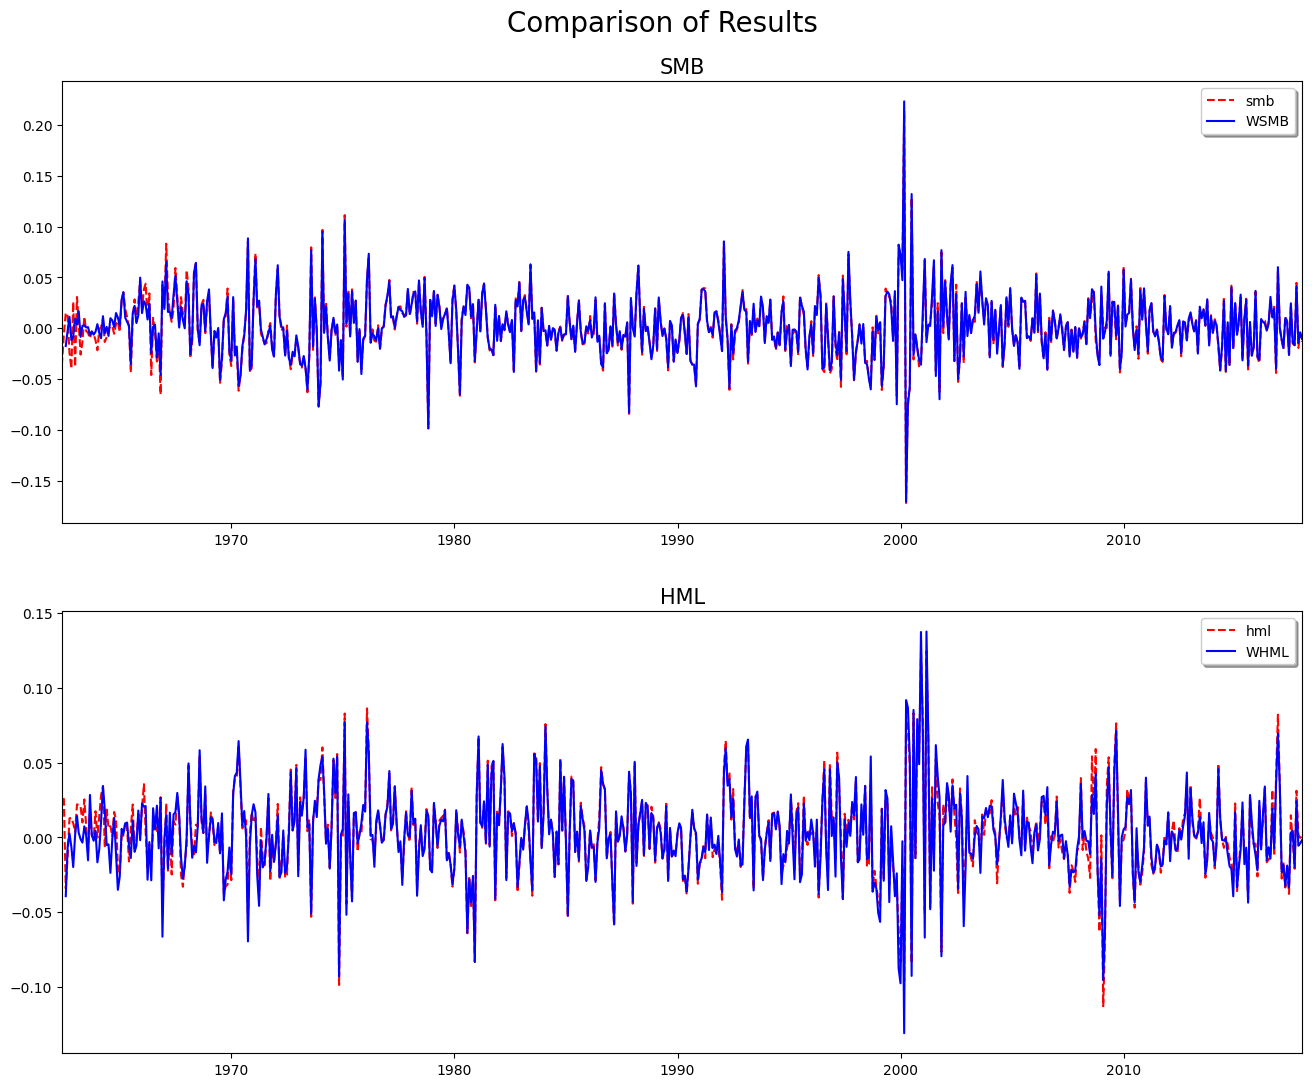

In [33]:
plt.figure(figsize=(16,12))
plt.suptitle('Comparison of Results', fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title('SMB', fontsize=15)
ax1.set_xlim([dt.datetime(1962,6,1), dt.datetime(2017,12,31)])
ax1.plot(_ffcomp['smb'], 'r--', _ffcomp['WSMB'], 'b-')
ax1.legend(('smb','WSMB'), loc='upper right', shadow=True)

ax2 = plt.subplot(212)
ax2.set_title('HML', fontsize=15)
ax2.plot(_ffcomp['hml'], 'r--', _ffcomp['WHML'], 'b-')
ax2.set_xlim([dt.datetime(1962,6,1), dt.datetime(2017,12,31)])
ax2.legend(('hml','WHML'), loc='upper right', shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)

plt.show()

In [35]:
import pandas as pd

# Adjust the skiprows value based on where your data starts
ff_data = pd.read_csv("F-F_Research_Data_Factors.CSV", skiprows=3)

# Rename columns
ff_data.rename(columns={"Unnamed: 0": "Date"}, inplace=True)

# Convert 'Date' column to datetime
ff_data["Date"] = pd.to_datetime(ff_data["Date"], format="%Y%m", errors='coerce')

# Drop rows where 'Date' couldn't be converted (likely extra text rows)
ff_data = ff_data.dropna(subset=["Date"])

print(ff_data.head())


        Date    Mkt-RF       SMB       HML        RF
0 1926-07-01      2.96     -2.56     -2.43      0.22
1 1926-08-01      2.64     -1.17      3.82      0.25
2 1926-09-01      0.36     -1.40      0.13      0.23
3 1926-10-01     -3.24     -0.09      0.70      0.32
4 1926-11-01      2.53     -0.10     -0.51      0.31


In [43]:
import wrds
import pandas as pd
import statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

# -------------------------------
# 1. Connect to WRDS and pull CRSP data
# -------------------------------
conn = wrds.Connection()
query = """
    SELECT date, ret
    FROM crsp.msf
    WHERE date >= '2000-01-01'
    ORDER BY date
"""
crsp_data = conn.raw_sql(query)
crsp_data['date'] = pd.to_datetime(crsp_data['date'])

# Create portfolio returns as an equally weighted average by month
portfolio_returns = crsp_data.groupby("date")["ret"].mean().reset_index()
portfolio_returns.rename(columns={"ret": "Return"}, inplace=True)

print("CRSP portfolio data date range:", portfolio_returns['date'].min(), portfolio_returns['date'].max())

# -------------------------------
# 2. Prepare the Fama-French factor data (ff_data)
# -------------------------------
# Load and clean Fama-French data from CSV (assume it's in the same folder)
# Skip the first 3 lines of header info, rename the date column, and convert to datetime
ff_data = pd.read_csv("F-F_Research_Data_Factors.CSV", skiprows=3)
ff_data.rename(columns={"Unnamed: 0": "Date"}, inplace=True)

# Convert 'Date' from YYYYMM to datetime and shift to month-end
ff_data['Date'] = pd.to_datetime(ff_data['Date'], format="%Y%m", errors='coerce') + MonthEnd(0)

# Drop any rows where conversion failed
ff_data = ff_data.dropna(subset=["Date"])

print("Fama-French data date range:", ff_data['Date'].min(), ff_data['Date'].max())

# -------------------------------
# 3. Merge DataFrames
# -------------------------------
# Merge on the date columns: CRSP uses 'date' and ff_data uses 'Date'
merged_data = pd.merge(portfolio_returns, ff_data, left_on="date", right_on="Date", how="inner")
print("Merged data shape:", merged_data.shape)
if merged_data.empty:
    raise ValueError("No overlapping dates between CRSP and Fama-French data. Please check your date ranges.")

# Remove any extra whitespace from column names
merged_data.columns = merged_data.columns.str.strip()

# Convert relevant columns to numeric
cols_to_numeric = ["Return", "RF", "Mkt-RF", "SMB", "HML"]
for col in cols_to_numeric:
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# Compute excess returns: portfolio return minus risk-free rate
merged_data["Excess Return"] = merged_data["Return"] - merged_data["RF"]

# Optional: check data types
print(merged_data[["Mkt-RF", "SMB", "HML", "Excess Return"]].dtypes)

# Force conversion to float (if not already)
X = merged_data[["Mkt-RF", "SMB", "HML"]].astype(float)
X = sm.add_constant(X)
y = merged_data["Excess Return"].astype(float)

# -------------------------------
# 4. Run the Regression
# -------------------------------
model = sm.OLS(y, X).fit()
print(model.summary())


WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
CRSP portfolio data date range: 2000-01-31 00:00:00 2024-12-31 00:00:00
Fama-French data date range: 1926-07-31 00:00:00 2024-12-31 00:00:00
Merged data shape: (212, 7)
Mkt-RF           float64
SMB              float64
HML              float64
Excess Return    Float64
dtype: object
                            OLS Regression Results                            
Dep. Variable:          Excess Return   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     12.82
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           1.02e-07
Time:                        18:06:49   Log-Likelihood:                 87.417
No. Observations:                 212   AIC:                            -166.8
Df Res